In [ ]:
#!pip install pycaret chainladder optuna

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'

# Machine Learning in Python

Machine learning


## Python basics

## Scikit-Learn
Estimators and their properties
 * hyperparameters vs fitted parameters_
 * `fit`, `predict`, `transform`, `score` methods

Classification Example - Determine LOB from triangle

SKLEARN
  * Simple train-test split
  * kfold Cross-validation
  * Gridsearch parameter tuning

AutoML (pycaret)


Automated parameter tuning
Optuna


In [1]:
import chainladder as cl
import pandas as pd

# Intro to scikit-learn

![](https://scikit-learn.org/stable/_static/ml_map.png)

`sklearn` is the defacto standard Machine Learning  API in python. Almost everything is an estimator in `sklearn`.

📜 All estimator objects can optionally be configured with **hyper**parameters to uniquely specify the model being built. This is done ahead of pushing any data through the model.

Estimators are instances of a class (which is denoted by Uppercase naming convention).

```python
estimator = Estimator(param1=1, param2=2)
```

Creating an instance of a model is as simple as adding parenthesis at the end of the class name.

In [166]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model

LinearRegression()

`sklearn` has sensible default hyperparameters. These can be viewed and optionally overridden.

In [167]:
model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

Note that we can set our **hyperparameters** in the absence of looking at any data. These parameters are there to tell the model how it should behave during the fitting process.

In [195]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

📜 All estimator objects expose a `fit` method that takes as input, `X`:

```python
estimator.fit(X, y)
```
 

Models also optionally support a response, `y` or and weights, `sample_weight`.

Let's create some data to explore the concept.

In [190]:
import numpy as np

data = pd.DataFrame(
    {'X': np.linspace(-50, 50, 100), 
     'y': 1.5 * X  + 30 + np.random.normal(0, 15, 100)})
data.head()

,X,y
0,-50.000000,-62.565031
1,-48.989899,-42.754012
2,-47.979798,-18.260358
3,-46.969697,-38.733277
4,-45.959596,-49.983364


We know the linear equation that generated this data, but becuase we added an error term, we can see the errors in our data.

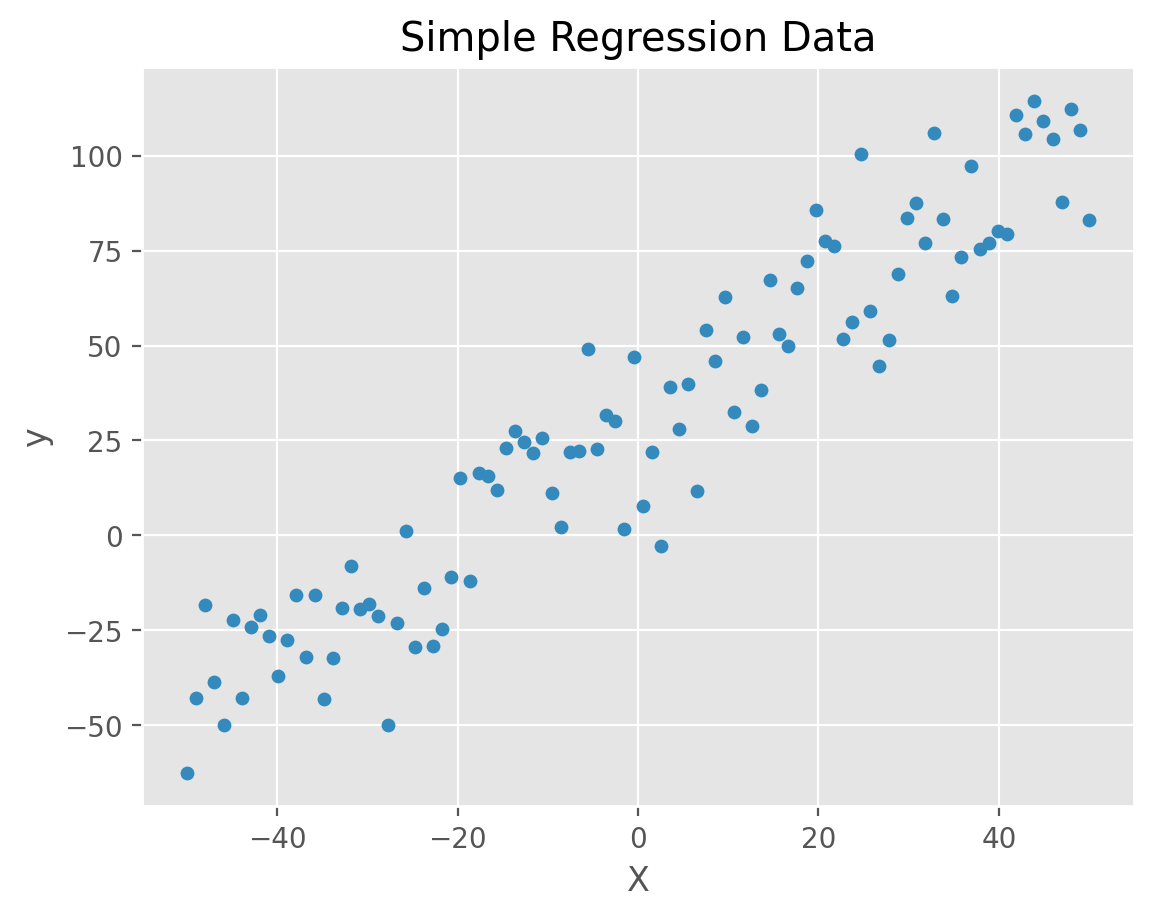

In [199]:
data.plot(kind='scatter', x='X', y='y', title='Simple Regression Data');

Let's fit our model to our data.

In [220]:
model.fit(data[['X']], data['y'])

LinearRegression()

It looks like nothing happened, but in actuality, our model has be fitted to the data.  The `model` object itself displays the same, but it now has additional features.  

📜 When a model is fit, the fitted attributes are denoted by a trailing **underscore**. 

```python
estimator.estimated_param_
```

The use of the underscore is a key API design style of scikit-learn that allows for the quicker recognition of fitted parameters vs hyperparameters:

In [221]:
f'The slope of the model is {model.coef_} and the intercept is {model.intercept_}.'

'The slope of the model is [1.52709365] and the intercept is 29.46818836898374.'

Can we do statistical inference with `sklearn`?

Only in limited ways at an overall level. There are no coefficient-specific t-statistics, p-values, etc, associated with this model retained by `sklearn`. The machine learning focus of the library promotes overall model performance over a

In [232]:
model.score(data[['X']], data['y'])

0.900839582031013

In [ ]:
predictions = model.predict(data[['X']])

In [242]:
metrics.mean_squared_error(data['y'], predictions)

218.2363876071182

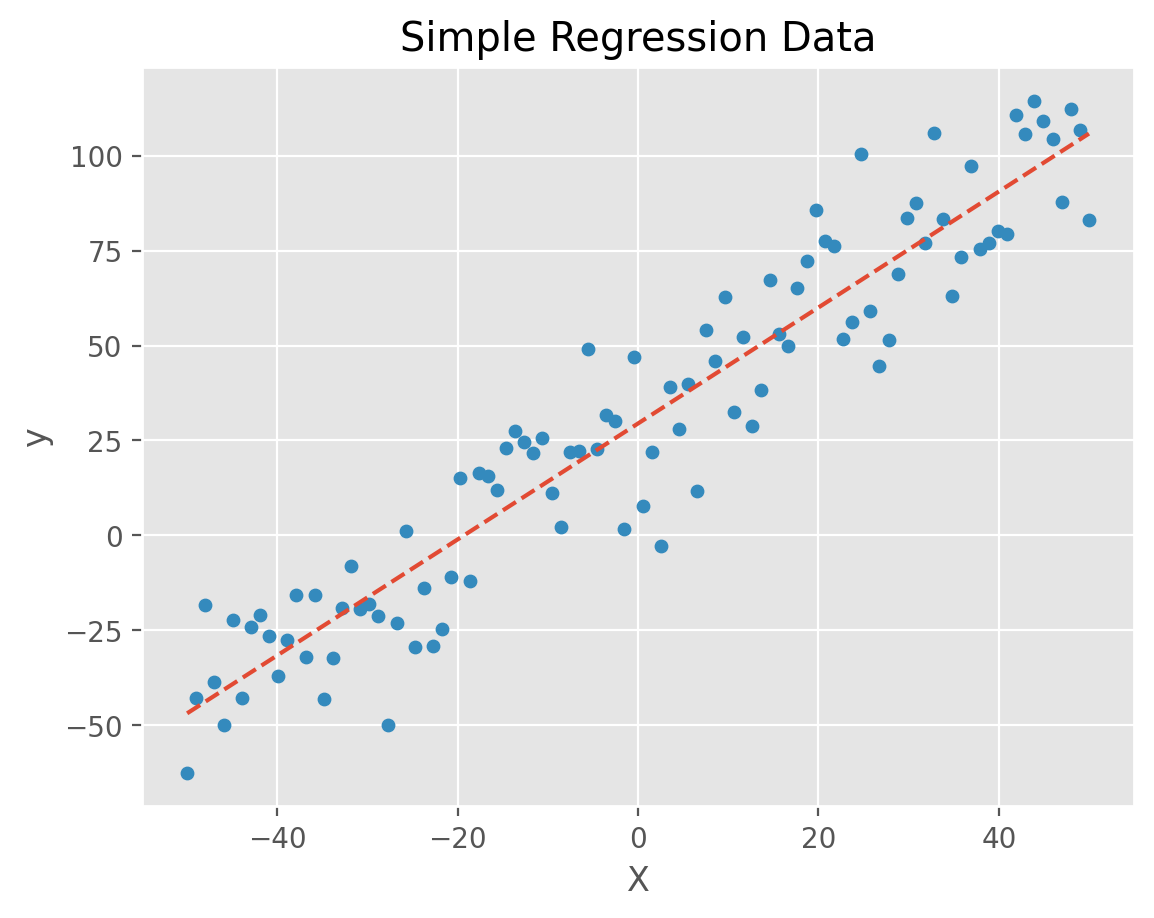

In [226]:
ax = data.plot(kind='scatter', x='X', y='y', title='Simple Regression Data');

pd.concat(
    (data[['X']], pd.Series(predictions, name='y')), 
    axis=1
).plot(
    kind='line', x='X', y='y', 
    ax=ax, legend=False, 
    linestyle='dashed');

These are the very basics of `sklearn`, but let's try something on a 

# The Dataset - a segue into `chainladder`

Let's explore the `clrd`  ([CAS Loss Reserve Database](https://www.casact.org/publications-research/research/research-resources/loss-reserving-data-pulled-naic-schedule-p)) dataset stored within the `chainladder` python package.

In [4]:
clrd = cl.load_sample('clrd')
clrd

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 6, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet]"


We are using a `chainladder.Triangle` to explore the dataset.

In [244]:
type(clrd)

chainladder.core.triangle.Triangle

The `Triangle` object is like a pandas DataFrame with an individual triangle as a datatype.  We can have different rows of a triangle representing Companies and Lines of Business.  We can have different rows covering the different measures like Paid Loss, Premium, etc.  The result is a 4D object (Table of Triangles):


![](https://raw.githubusercontent.com/casact/chainladder-python/master/docs/images/triangle_graphic.PNG)

## Similarity to Pandas
The `Triangle` object is very similar to a pandas DataFrame and uses a subset of the pandas API for data manipulation. There are several advantages in having a dedicated Triangle object:

* Actuaries work with sets of triangles. DataFrames, being two dimensional, support single triangles with grace but become unwieldy with multiple triangles.
* We can carry through the meaningful pandas functionality while also supporting triangle specific methods not found in pandas
* Improved memory footprint with sparse array representation in backend
* Calculated fields with “virtual” columns allows for lazy column evaluation of Triangles as well as improved memory footprint for larger triangles.

Ultimately, there are a lot of things pandas can do that are not relevant to reserving, and there are a lot of things a Triangle needs to do that are not handled easily with pandas.  That said, a lot of pandas functionality works with Triangles.  For example, we can calculate aggregate values over all "rows" of the `Triangle`:

In [9]:
clrd['CumPaidLoss'].sum()

,12,24,36,48,60,72,84,96,108,120
1988,"3,577,780","7,059,966","8,826,151","9,862,687","10,474,698","10,814,576","10,994,014","11,091,363","11,171,590","11,203,949"
1989,"4,090,680","7,964,702","9,937,520","11,098,588","11,766,488","12,118,790","12,311,629","12,434,826","12,492,899",
1990,"4,578,442","8,808,486","10,985,347","12,229,001","12,878,545","13,238,667","13,452,993","13,559,557",,
1991,"4,648,756","8,961,755","11,154,244","12,409,592","13,092,037","13,447,481","13,642,414",,,
1992,"5,139,142","9,757,699","12,027,983","13,289,485","13,992,821","14,347,271",,,,
1993,"5,653,379","10,599,423","12,953,812","14,292,516","15,005,138",,,,,
1994,"6,246,447","11,394,960","13,845,764","15,249,326",,,,,,
1995,"6,473,843","11,612,151","14,010,098",,,,,,,
1996,"6,591,599","11,473,912",,,,,,,,
1997,"6,451,896",,,,,,,,,


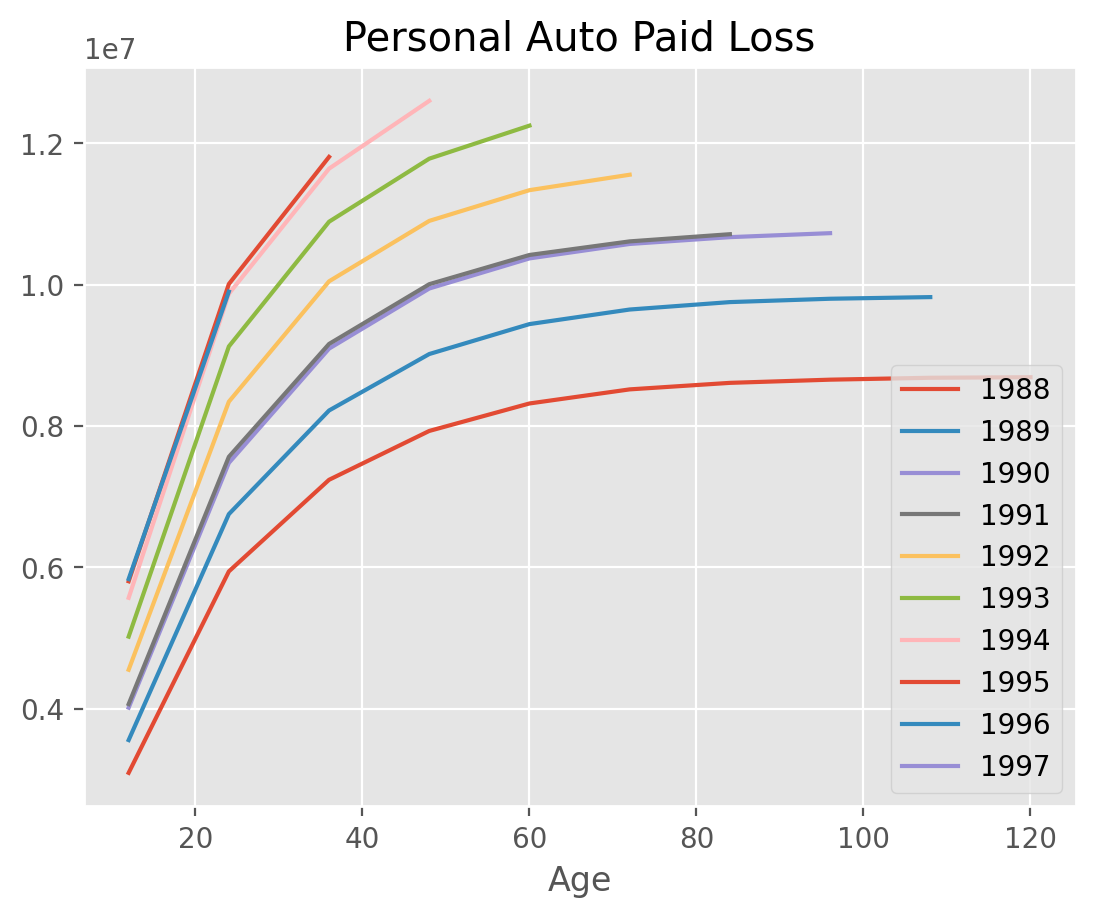

In [21]:
clrd[clrd['LOB']=='ppauto']['CumPaidLoss'].sum().T.plot(xlabel='Age', title='Personal Auto Paid Loss');

We can also explore the age-to-age factors or `link_ratio` of any triangle.

In [35]:
clrd[clrd['LOB']=='ppauto']['CumPaidLoss'].sum().link_ratio.heatmap()

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1988,1.9215,1.2181,1.0955,1.0490,1.0240,1.0108,1.0052,1.0031,1.0009
1989,1.8988,1.2171,1.0972,1.0470,1.0218,1.0109,1.0049,1.0024,
1990,1.8626,1.2162,1.0935,1.0428,1.0197,1.0091,1.0053,,
1991,1.8606,1.2111,1.0923,1.0413,1.0184,1.0096,,,
1992,1.8332,1.2041,1.0851,1.0399,1.0193,,,,
1993,1.8178,1.1934,1.0819,1.0397,,,,,
1994,1.7724,1.1794,1.0824,,,,,,
1995,1.7247,1.1797,,,,,,,
1996,1.6967,,,,,,,,


Creating a new column in a Triangle looks identical to the same operation in pandas.

In [6]:
clrd['CaseIncurLoss'] = clrd['IncurLoss'] - clrd['BulkLoss']
clrd

,Triangle Summary
Valuation:,1997-12
Grain:,OYDY
Shape:,"(775, 7, 10, 10)"
Index:,"[GRNAME, LOB]"
Columns:,"[IncurLoss, CumPaidLoss, BulkLoss, EarnedPremDIR, EarnedPremCeded, EarnedPremNet, CaseIncurLoss]"


GRNAME                               LOB     
Adriatic Ins Co                      othliab     0.908640
                                     ppauto      0.168831
Aegis Grp                            comauto     0.235294
                                     othliab     0.000000
                                     ppauto      0.737830
                                                   ...   
Yasuda Fire & Marine Ins Co Of Amer  ppauto      0.309158
                                     prodliab    0.618130
                                     wkcomp      0.352835
Yel Co Ins                           comauto     0.000000
Zurich Ins (Guam) Inc                wkcomp      0.000000
Name: Reinsurance Percent, Length: 775, dtype: float64

In [391]:
clrd.iloc[0]['EarnedPremCeded'].latest_diagonal.sum('origin')

915.0

In [392]:
clrd['EarnedPremDIR']).latest_diagonal.sum('origin')

1007.0

`chainladder` has estimators that follow the sklearn convention too. We can define a model and fit it to some data. 

We can define a model by creating an instance of a `chainladder` estimator. Here we take a simple average of link-ratios for each development age of a Triangle.

In [353]:
dev_model = cl.Development(average='simple')

Unlike a traditional classification or regression problem, reserving problems don't typically have a response variable, `y`.  In `chainladder`, ignoring `y` is expected.

In [354]:
dev_model.fit(X=clrd['CumPaidLoss'])

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:58: RuntimeWarning: Mean of empty slice
  xp.nansum(w * x * y, axis) - xp.nansum(x * w, axis) * xp.nanmean(y, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:60: RuntimeWarning: Mean of empty slice
  xp.nansum(w * x * x, axis) - xp.nanmean(x, axis) * xp.nansum(w * x, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:62: RuntimeWarning: Mean of empty slice
  intercept = xp.nanmean(y, axis) - slope * xp.nanmean(x, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:115: RuntimeWarning: overflow encountered in exp
  fill_ = xp.exp(reg.x * slope + intercept) * (1 - w)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\core\dunders.py:307: RuntimeWarning: overflow encountered in square
  obj.values = xp.nan_to_num(obj

Development(average='simple')

In [355]:
paid_link_ratios = dev_model.ldf_
paid_link_ratios

,Triangle Summary
Valuation:,2261-12
Grain:,OYDY
Shape:,"(775, 1, 1, 9)"
Index:,"[GRNAME, LOB]"
Columns:,[CumPaidLoss]


In [356]:
paid_link_ratios.loc['Allstate Ins Co Grp'].loc['wkcomp']

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),2.3863,1.3624,1.1702,1.0901,1.0579,1.0461,1.0320,1.0348,1.0109


In [357]:
inc_link_ratios = dev_model.fit(X=clrd['CaseIncurLoss']).ldf_

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:58: RuntimeWarning: Mean of empty slice
  xp.nansum(w * x * y, axis) - xp.nansum(x * w, axis) * xp.nanmean(y, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:60: RuntimeWarning: Mean of empty slice
  xp.nansum(w * x * x, axis) - xp.nanmean(x, axis) * xp.nansum(w * x, axis)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\utils\weighted_regression.py:62: RuntimeWarning: Mean of empty slice
  intercept = xp.nanmean(y, axis) - slope * xp.nanmean(x, axis)


In [358]:
inc_link_ratios.loc['Allstate Ins Co Grp'].loc['wkcomp']

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),1.3068,1.0507,1.0377,1.0181,1.0135,1.0128,1.0103,1.0105,0.9992


In [406]:
clrd['CaseReserves'] = clrd['CaseIncurLoss'] - clrd['CumPaidLoss']

In [408]:
clrd['CaseReserves'].iloc[0]

,12,24,36,48,60,72,84,96,108,120
1988,,,,,,,,,,
1989,,,,,,,,,,
1990,,,,,,,,,,
1991,,,,,,,,,,
1992,,,,,,,,,,
1993,,,,,,,,,,
1994,,,,,,,,,,
1995,,7.00,,,,,,,,
1996,,,,,,,,,,
1997,36.00,,,,,,,,,


In [418]:
increm_paid_per_case = (clrd['CumPaidLoss'].cum_to_incr().iloc[..., 1:] / clrd['CaseReserves'].iloc[..., :-1].values).mean('origin').to_frame()

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\core\pandas.py:364: RuntimeWarning: Mean of empty slice
  obj.values = func(obj.values, axis=axis, *args, **kwargs)


In [419]:
increm_paid_per_case.columns = [str(c) + ' Incremental Paid per Case' for c in increm_paid_per_case.columns]

Is it possible to predict which line of business a triangle comes from just based on the triangle data?

Let's do some feature engineering.

In [359]:
paid_link_ratios = paid_link_ratios.to_frame()
inc_link_ratios = inc_link_ratios.to_frame()
paid_pct =(clrd['CumPaidLoss'].cum_to_incr() / clrd['CumPaidLoss']).mean(axis='origin').to_frame()
inc_pct = (clrd['CaseIncurLoss'].cum_to_incr() / clrd['CaseIncurLoss']).mean(axis='origin').to_frame()
paid_to_inc = (clrd['CumPaidLoss'] / clrd['CaseIncurLoss']).mean(axis='origin').to_frame()

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\core\pandas.py:364: RuntimeWarning: Mean of empty slice
  obj.values = func(obj.values, axis=axis, *args, **kwargs)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\core\pandas.py:364: RuntimeWarning: Mean of empty slice
  obj.values = func(obj.values, axis=axis, *args, **kwargs)
C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\chainladder\core\pandas.py:364: RuntimeWarning: Mean of empty slice
  obj.values = func(obj.values, axis=axis, *args, **kwargs)


In [370]:
paid_link_ratios.columns = [c + ' Paid Link Ratio' for c in paid_link_ratios.columns]
inc_link_ratios.columns = [c + ' Incurred Link Ratio' for c in inc_link_ratios.columns]
paid_pct.columns = [str(c) + ' Paid Percent' for c in paid_pct.columns]
inc_pct.columns = [str(c) + ' Incurred Percent' for c in inc_pct.columns]
paid_to_inc.columns = [str(c) + ' Paid to Incurred' for c in paid_to_inc.columns]

In [420]:
data = pd.concat((paid_link_ratios, inc_link_ratios, paid_pct, inc_pct, paid_to_inc,
                 (clrd['EarnedPremCeded'].latest_diagonal.sum('origin') / clrd['EarnedPremDIR'].latest_diagonal.sum('origin')).to_frame().rename('Reinsurance Percent'),
                  increm_paid_per_case
                 ), axis=1).reset_index().drop('GRNAME', axis=1).set_index('LOB')
data.head()

,12-24 Paid Link Ratio,24-36 Paid Link Ratio,36-48 Paid Link Ratio,48-60 Paid Link Ratio,60-72 Paid Link Ratio,72-84 Paid Link Ratio,84-96 Paid Link Ratio,96-108 Paid Link Ratio,108-120 Paid Link Ratio,12-24 Incurred Link Ratio,...,Reinsurance Percent,24 Incremental Paid per Case,36 Incremental Paid per Case,48 Incremental Paid per Case,60 Incremental Paid per Case,72 Incremental Paid per Case,84 Incremental Paid per Case,96 Incremental Paid per Case,108 Incremental Paid per Case,120 Incremental Paid per Case
LOB,,,,,,,,,,,,,,,,,,,,,
othliab,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.908640,0.000000,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ppauto,1.357143,1.000000,1.382353,1.000000,1.000000,1.000000,1.000000,1.0,1.0,0.640034,...,0.168831,0.112821,0.000000,0.650000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
comauto,2.625000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.833333,...,0.235294,0.325000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
othliab,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
ppauto,3.417789,1.222703,1.070270,1.023283,1.021659,1.006826,1.015241,1.0,1.0,1.060302,...,0.737830,0.708382,0.665836,0.400078,0.400441,0.755219,0.421053,0.298246,0.0,0.0


# A classification problem

In [421]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(data.index)

pd.Series(le.classes_).to_dict()

{0: 'comauto',
 1: 'medmal',
 2: 'othliab',
 3: 'ppauto',
 4: 'prodliab',
 5: 'wkcomp'}

In [422]:
y = le.transform(data.index)

In [423]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  data, y,
  test_size = 0.25,
  random_state = 1234)

In [424]:
import lightgbm
from sklearn.metrics import confusion_matrix
model = lightgbm.LGBMClassifier().fit(X=X_train.values, y=y_train)


In [425]:
cm = pd.DataFrame(
    confusion_matrix(y_train, model.predict(X_train)),
    index=le.classes_,
    columns=le.classes_)

(cm / cm.sum(1)).style.background_gradient(cmap='Blues', axis=1)

,comauto,medmal,othliab,ppauto,prodliab,wkcomp
comauto,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
medmal,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
othliab,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
ppauto,0.000000,0.000000,0.005650,0.991150,0.000000,0.000000
prodliab,0.000000,0.000000,0.011299,0.000000,0.962264,0.000000
wkcomp,0.000000,0.000000,0.011299,0.000000,0.000000,0.980000


In [426]:
f'Model accuracy: {model.score(X_train, y_train)}'

'Model accuracy: 0.9913941480206541'

In [427]:
f'Model accuracy: {np.diag(cm).sum() / cm.sum().sum()}' 

'Model accuracy: 0.9913941480206541'

This is amazing accuracy! But we're skeptical that it is representative of how good the model will perform on a holdout dataset.  We can use cross-validation to 
emulate the results expected on a true holdout set.
![](https://upload.wikimedia.org/wikipedia/commons/4/4b/KfoldCV.gif)

In `sklearn`, this is achieved by passing the estimator and the data into the `cross_val_score` function:

In [428]:
from sklearn.model_selection import cross_val_score

f'Expected model accuracy on a holdout set: {cross_val_score(model, X_train, y_train).mean()}'  

'Expected model accuracy on a holdout set: 0.44404656646035956'

In [429]:
print(f'Model accuracy: {model.score(X_test, y_test)}')

cm = pd.DataFrame(
    confusion_matrix(y_test, model.predict(X_test)),
    index=le.classes_,
    columns=le.classes_)

(cm / cm.sum(1)).style.background_gradient(cmap='Blues', axis=1)

Model accuracy: 0.4845360824742268


,comauto,medmal,othliab,ppauto,prodliab,wkcomp
comauto,0.341463,0.000000,0.152542,0.212121,0.235294,0.218750
medmal,0.024390,0.166667,0.118644,0.000000,0.058824,0.031250
othliab,0.219512,0.166667,0.610169,0.121212,0.294118,0.093750
ppauto,0.146341,0.000000,0.050847,0.666667,0.058824,0.031250
prodliab,0.048780,0.000000,0.169492,0.000000,0.294118,0.000000
wkcomp,0.048780,0.000000,0.101695,0.242424,0.058824,0.468750


In [437]:
#cross_val_score(model, X_train, y_train)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [442]:
pd.Series({
    'RandomForestClassifier': cross_val_score(RandomForestClassifier(), X_train, y_train).mean(),
    'GradientBoostingClassifier': cross_val_score(GradientBoostingClassifier(), X_train, y_train).mean(),
    'KNeighborsClassifier': cross_val_score(KNeighborsClassifier(), X_train, y_train).mean(),
    'XGBClassifier': cross_val_score(XGBClassifier(), X_train, y_train).mean(),
    'LGBMClassifier': cross_val_score(lightgbm.LGBMClassifier(), X_train, y_train).mean(),
}).sort_values()

KNeighborsClassifier          0.356292
LGBMClassifier                0.444047
XGBClassifier                 0.459490
GradientBoostingClassifier    0.459505
RandomForestClassifier        0.474993
dtype: float64

In [443]:
model = RandomForestClassifier().fit(X=X_train.values, y=y_train)

cm = pd.DataFrame(
    confusion_matrix(y_test, model.predict(X_test)),
    index=le.classes_,
    columns=le.classes_)

(cm / cm.sum(1)).style.background_gradient(cmap='Blues', axis=1)

C:\Users\jbogaard\Miniconda3\envs\clrs\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,comauto,medmal,othliab,ppauto,prodliab,wkcomp
comauto,0.390244,0.000000,0.288136,0.121212,0.000000,0.125000
medmal,0.024390,0.166667,0.084746,0.030303,0.058824,0.062500
othliab,0.219512,0.083333,0.576271,0.151515,0.294118,0.156250
ppauto,0.219512,0.000000,0.050847,0.575758,0.000000,0.062500
prodliab,0.024390,0.000000,0.220339,0.000000,0.176471,0.000000
wkcomp,0.048780,0.000000,0.101695,0.242424,0.000000,0.500000


In [ ]:
Feature Engineering
Parameter Tuning
Algorithm Selection


## AutoML

Abstraction on underlying techniques

In [1]:
from pycaret.classification import ClassificationExperiment
s = ClassificationExperiment()
#s.setup(data.reset_index(), target = 'LOB', session_id = 123)

ModuleNotFoundError: No module named 'scikitplot'

In [444]:
cross_val_score?

Signature:
cross_val_score(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    scoring=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    error_score=nan,
)
Docstring:
Evaluate a score by cross-validation.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
estimator : estimator object implementing 'fit'
    The object to use to fit the data.

X : array-like of shape (n_samples, n_features)
    The data to fit. Can be for example a list, or an array.

y : array-like of shape (n_samples,) or (n_samples, n_outputs),             default=None
    The target variable to try to predict in the case of
    supervised learning.

groups : array-like of shape (n_samples,), default=None
    Group labels for the samples used while splitting the dataset into
    train/test set. Only used in conjunction with a "Group" :term:`cv`
    instance (e.g., :class:`GroupKFold`).

scoring : str or callable, default=None

In [53]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.4833,0.7537,0.4833,0.4669,0.4601,0.3280,0.3344,2.8000
et,Extra Trees Classifier,0.4760,0.7448,0.4760,0.4508,0.4473,0.3156,0.3260,0.3620
rf,Random Forest Classifier,0.4686,0.7672,0.4686,0.4567,0.4403,0.3055,0.3150,0.4780
lightgbm,Light Gradient Boosting Machine,0.4669,0.7515,0.4669,0.4444,0.4466,0.3106,0.3156,1.1740
xgboost,Extreme Gradient Boosting,0.4649,0.7568,0.4649,0.4532,0.4503,0.3116,0.3154,1.0530
knn,K Neighbors Classifier,0.3764,0.6692,0.3764,0.3459,0.3512,0.1964,0.2003,0.0630
qda,Quadratic Discriminant Analysis,0.3653,0.5983,0.3653,0.2557,0.2954,0.1646,0.1769,0.1320
dt,Decision Tree Classifier,0.3579,0.5918,0.3579,0.3618,0.3542,0.1854,0.1869,0.0660
lr,Logistic Regression,0.3544,0.6575,0.3544,0.2899,0.2973,0.1551,0.1675,0.3660
ada,Ada Boost Classifier,0.3269,0.6485,0.3269,0.3442,0.3064,0.1392,0.1432,0.2610


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [57]:
print(best)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [352]:
model.feature_name_

['Column_0',
 'Column_1',
 'Column_2',
 'Column_3',
 'Column_4',
 'Column_5',
 'Column_6',
 'Column_7',
 'Column_8',
 'Column_9',
 'Column_10',
 'Column_11',
 'Column_12',
 'Column_13',
 'Column_14',
 'Column_15',
 'Column_16',
 'Column_17',
 'Column_18',
 'Column_19',
 'Column_20',
 'Column_21',
 'Column_22',
 'Column_23',
 'Column_24',
 'Column_25',
 'Column_26',
 'Column_27',
 'Column_28',
 'Column_29',
 'Column_30',
 'Column_31',
 'Column_32',
 'Column_33',
 'Column_34',
 'Column_35',
 'Column_36',
 'Column_37',
 'Column_38',
 'Column_39',
 'Column_40',
 'Column_41',
 'Column_42',
 'Column_43',
 'Column_44',
 'Column_45',
 'Column_46',
 'Column_47']

In [349]:
dev_model.get_params()

{'average': 'simple',
 'drop': None,
 'drop_above': inf,
 'drop_below': 0.0,
 'drop_high': None,
 'drop_low': None,
 'drop_valuation': None,
 'fillna': None,
 'groupby': None,
 'n_periods': -1,
 'preserve': 1,
 'sigma_interpolation': 'log-linear'}